In [25]:
import os
import sys

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import cv2

import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [2]:
real_dir = '../input/real-and-fake-face-detection/real_and_fake_face/training_real/'
real_path = os.listdir(real_dir)

fake_dir = '../input/real-and-fake-face-detection/real_and_fake_face/training_fake/'
fake_path = os.listdir(fake_dir)

In [5]:
def load_img(path):
    '''Loading images from directory 
    and changing color space from cv2 standard BGR to RGB 
    for better visualization'''
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

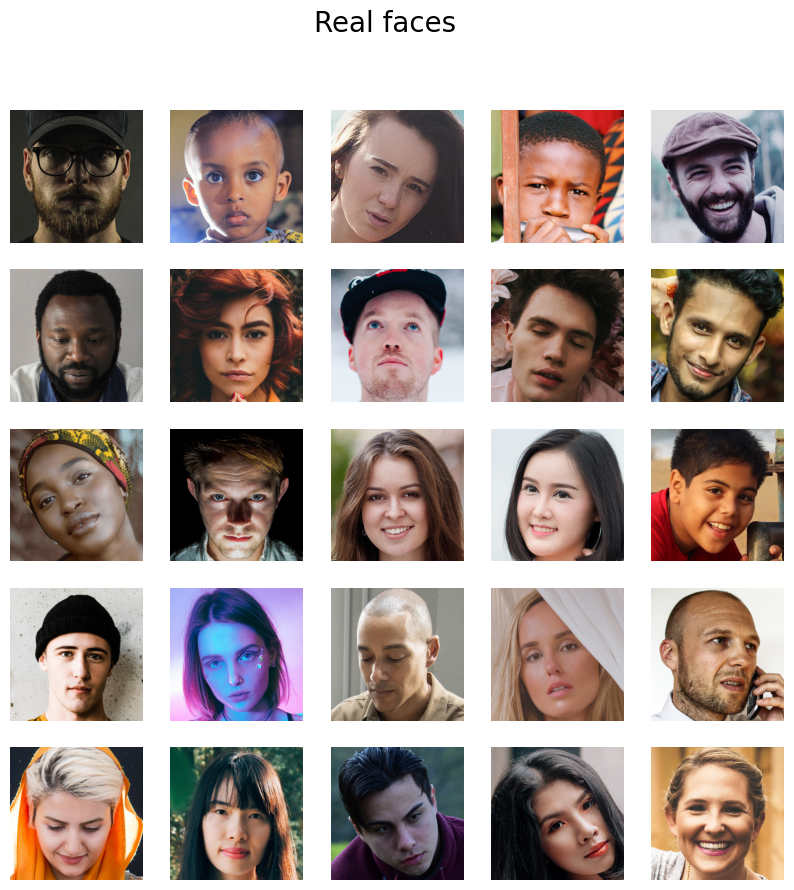

In [6]:
fig = plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(real_dir + real_path[i]))
    plt.suptitle("Real faces", fontsize=20)
    plt.axis('off')

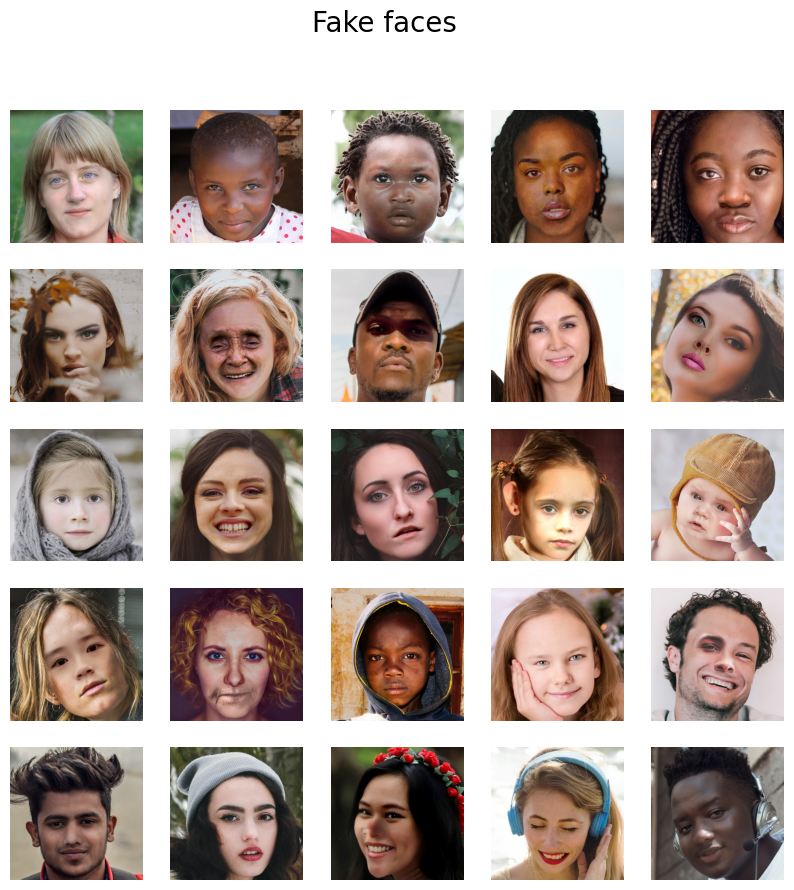

In [7]:
fig = plt.figure(figsize=(10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(load_img(fake_dir + fake_path[i]))
    plt.suptitle("Fake faces", fontsize=20)
    plt.axis('off')

In [8]:
real_df = pd.DataFrame({'image_path': real_dir + real_path[i], 'label': 1} for i in range(0, 1081))
fake_df = pd.DataFrame({'image_path': fake_dir + fake_path[i], 'label': 0} for i in range(0, 960))

In [9]:
df = pd.concat([real_df, fake_df], ignore_index=True)
df.tail(10)

image_path  label
2031  ../input/real-and-fake-face-detection/real_and...      0
2032  ../input/real-and-fake-face-detection/real_and...      0
2033  ../input/real-and-fake-face-detection/real_and...      0
2034  ../input/real-and-fake-face-detection/real_and...      0
2035  ../input/real-and-fake-face-detection/real_and...      0
2036  ../input/real-and-fake-face-detection/real_and...      0
2037  ../input/real-and-fake-face-detection/real_and...      0
2038  ../input/real-and-fake-face-detection/real_and...      0
2039  ../input/real-and-fake-face-detection/real_and...      0
2040  ../input/real-and-fake-face-detection/real_and...      0

In [10]:
df = shuffle(df)
df = df.reset_index(drop=True)
df.head(10)

image_path  label
0  ../input/real-and-fake-face-detection/real_and...      1
1  ../input/real-and-fake-face-detection/real_and...      1
2  ../input/real-and-fake-face-detection/real_and...      1
3  ../input/real-and-fake-face-detection/real_and...      1
4  ../input/real-and-fake-face-detection/real_and...      1
5  ../input/real-and-fake-face-detection/real_and...      1
6  ../input/real-and-fake-face-detection/real_and...      0
7  ../input/real-and-fake-face-detection/real_and...      0
8  ../input/real-and-fake-face-detection/real_and...      0
9  ../input/real-and-fake-face-detection/real_and...      1

In [11]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [14]:
image_size = 224
batch_size = 64
num_epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
'cuda'

'cuda'

In [15]:
image_transforms = {'train_transform': A.Compose([A.Resize(image_size, image_size), 
                                                  A.HorizontalFlip(p=0.5), 
                                                  A.RandomBrightnessContrast(always_apply=False, 
                                                                             p=0.4),
                                                  A.Solarize(always_apply=False, 
                                                             p=0.4, 
                                                             threshold=(42, 42)),
                                                  A.MultiplicativeNoise(always_apply=False, 
                                                                        p=0.8, 
                                                                        multiplier=(0.6800000071525574, 1.409999966621399), 
                                                                        per_channel=True, 
                                                                        elementwise=True),
                                                  A.Normalize(mean=(0.485, 0.456, 0.406), 
                                                              std=(0.229, 0.224, 0.225), 
                                                              max_pixel_value=255.0, 
                                                              p=1.0), 
                                                  ToTensorV2()]),
                    
                   'validation_transform': A.Compose([A.Resize(image_size, image_size), 
                                                      A.Normalize(mean=(0.485, 0.456, 0.406), 
                                                                  std=(0.229, 0.224, 0.225), 
                                                                  max_pixel_value=255.0, 
                                                                  p=1.0), 
                                                      ToTensorV2()]),
                   'visualization_transform': A.Compose([A.Resize(image_size, image_size), 
                                                         A.HorizontalFlip(p=0.5), 
                                                         A.RandomBrightnessContrast(always_apply=False, 
                                                                                    p=0.4),
                                                  A.Solarize(always_apply=False, 
                                                             p=0.4, 
                                                             threshold=(42, 42)),
                                                  A.MultiplicativeNoise(always_apply=False, 
                                                                        p=0.8, 
                                                                        multiplier=(0.6800000071525574, 1.409999966621399), 
                                                                        per_channel=True, 
                                                                        elementwise=True)])}


In [16]:
class ImageDataset(Dataset):
    def __init__(self, image_labels, image_dir, transform=None, target_transform=None):
        self.image_labels = image_labels
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform
        
        
    def __len__(self):
        return len(self.image_labels)
    
    
    def __getitem__(self, index):
        image_path = self.image_dir.iloc[index]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.image_labels.iloc[index]
        if self.transform:
            image = self.transform(image=image)['image']
        if self.target_transform:
            label = self.target_transform(label=label)
        return image, label


In [18]:
train_label = train_df['label']
train_features = train_df['image_path']

val_label = val_df['label']
val_features = val_df['image_path']

train_dataset = ImageDataset(train_label, 
                             train_features, 
                             transform=image_transforms['train_transform'])
val_dataset = ImageDataset(val_label, 
                           val_features, 
                           transform=image_transforms['validation_transform'])
visual_train_dataset =  ImageDataset(train_label, 
                                     train_features, 
                                     transform=image_transforms['visualization_transform'])


In [19]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
visual_loader = DataLoader(visual_train_dataset, batch_size=batch_size, shuffle=True)

In [20]:
val_loader

In [21]:
visual_train_f, visual_train_t = next(iter(visual_loader))
print(f'Feature batch shape: {visual_train_f.size()}')
print(f'Target batch shape: {visual_train_t.size()}')

Feature batch shape: torch.Size([64, 224, 224, 3])
Target batch shape: torch.Size([64])


In [22]:
for item in visual_loader:
    img, label = item[0], item[1]
    print(img, label)

tensor([[[[ 58,  61,  66],
          [ 70,  73,  78],
          [ 67,  70,  75],
          ...,
          [ 68,  71,  78],
          [ 68,  71,  79],
          [ 67,  69,  81]],

         [[ 48,  51,  56],
          [ 66,  69,  74],
          [ 69,  72,  77],
          ...,
          [ 61,  61,  64],
          [ 65,  64,  69],
          [ 72,  71,  78]],

         [[ 70,  73,  78],
          [ 63,  66,  71],
          [ 61,  64,  69],
          ...,
          [ 76,  72,  73],
          [ 79,  75,  77],
          [ 81,  76,  81]],

         ...,

         [[ 63,  63,  76],
          [ 53,  53,  63],
          [ 59,  59,  67],
          ...,
          [ 82,  94,  92],
          [207,  37,  36],
          [100, 110, 113]],

         [[ 55,  57,  69],
          [ 56,  59,  68],
          [ 53,  56,  63],
          ...,
          [ 93, 107, 109],
          [207,  33,  29],
          [100, 114, 120]],

         [[ 56,  60,  71],
          [ 55,  58,  67],
          [ 51,  56,  62],
         

In [23]:
def plot_batch(features, target, batch_size=batch_size):
    '''Shows one batch of augmented images'''
    plt.figure(figsize=(10, 40))
    for i in range(batch_size):
        img = features[i]
        label = target[i]
        
        plt.subplot(16, 4, i+1)
        plt.title(f'Class: {label}')
        plt.imshow(img)
    plt.show()

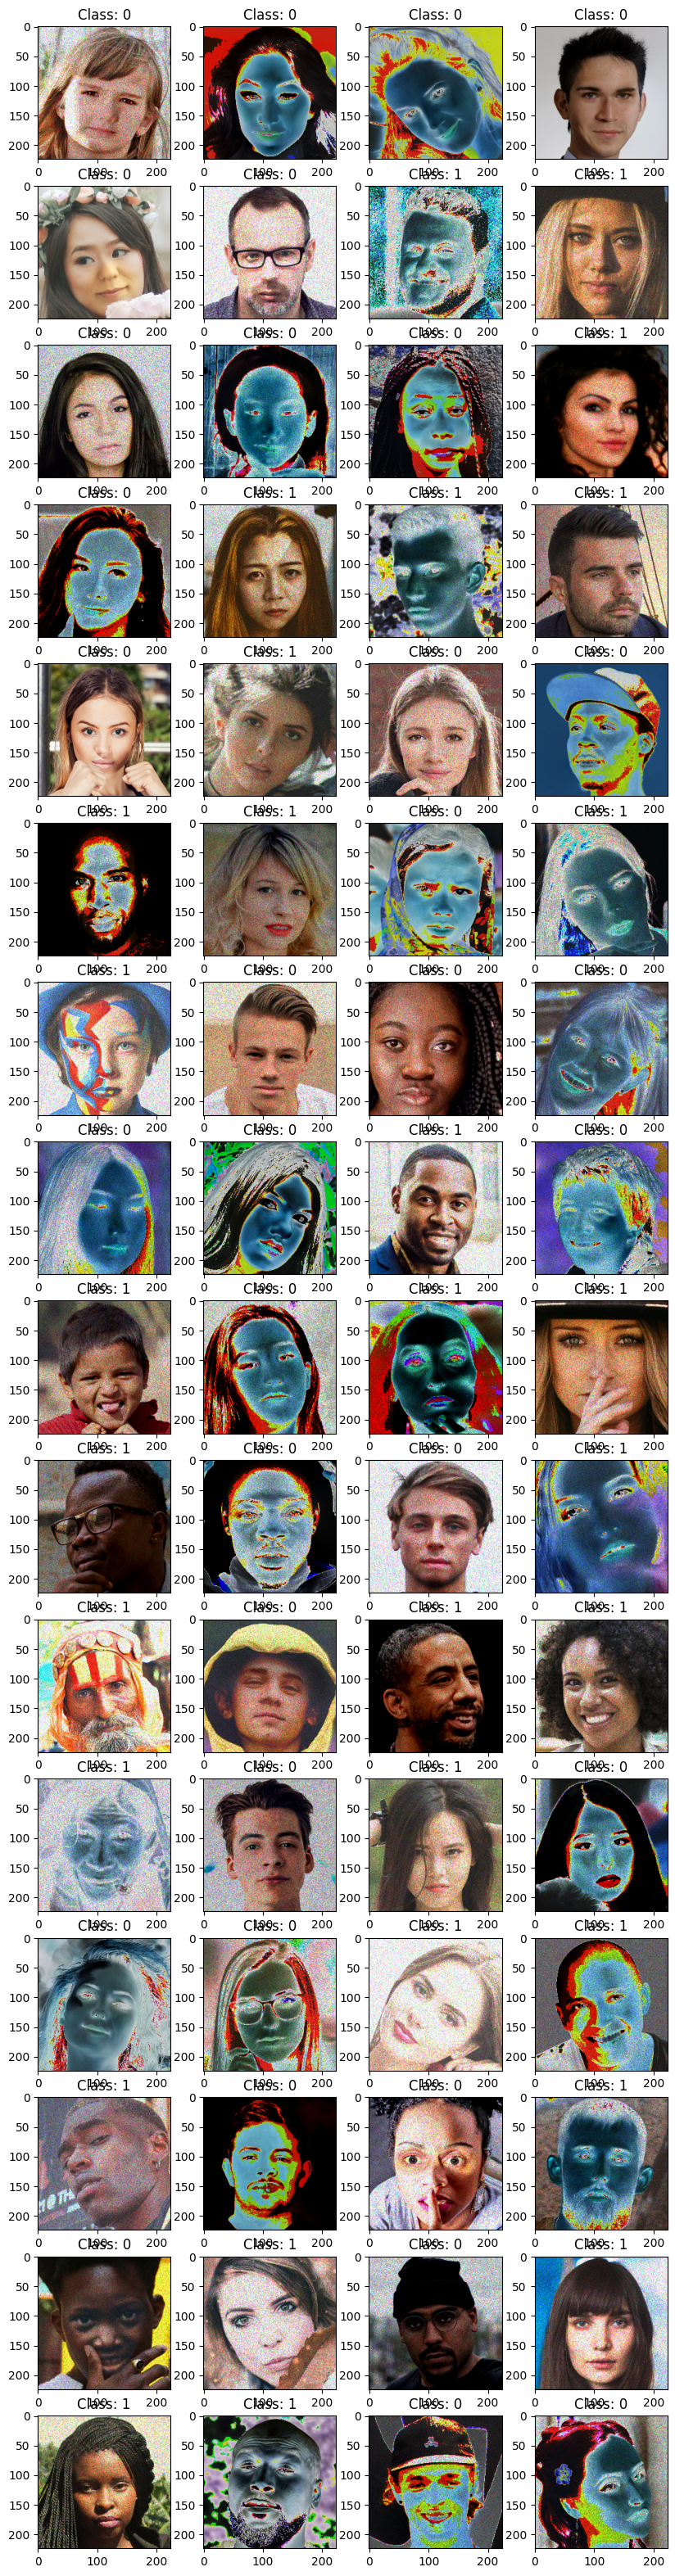

In [24]:
plot_batch(visual_train_f, visual_train_t)

In [3]:
pip install keras


  Obtaining dependency information for keras from https://files.pythonhosted.org/packages/fe/58/34d4d8f1aa11120c2d36d7ad27d0526164b1a8ae45990a2fede31d0e59bf/keras-2.14.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   - -------------------------------------- 0.1/1.7 MB 2.0 MB/s eta 0:00:01
   ----- ---------------------------------- 0.2/1.7 MB 2.8 MB/s eta 0:00:01
   -------- ------------------------------- 0.4/1.7 MB 2.9 MB/s eta 0:00:01
   ------------- -------------------------- 0.6/1.7 MB 3.2 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.7 MB 3.4 MB/s eta 0:00:01
   --------------------- ------------------ 0.9/1.7 MB 3.4 MB/s eta 0:00:01
   ----------------------- ---------------- 1.0/1.7 MB 3.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.2/1.7 MB 3.4 MB/s eta 0:00:01
   ------------------------------- -------- 1.4/1.7 MB 3.4 MB/s eta 0:00:01
   ------------------------------------ --- 1.6/1.7

In [5]:
pip install tensorflow


  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/80/6f/57d36f6507e432d7fc1956b2e9e8530c5c2d2bfcd8821bcbfae271cd6688/tensorflow-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for tensorflow-intel==2.14.0 from https://files.pythonhosted.org/packages/ad/6e/1bfe367855dd87467564f7bf9fa14f3b17889988e79598bc37bf18f5ffb6/tensorflow_intel-2.14.0-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/01/e4/dc0a1dcc4e74e08d7abedab278c795eef54a224363bb18f5692f416d834f/absl_py-2.0.0-py3-none-any.whl.metadata
  Obtaining dependency information for flatbuffers>=23.5.26 from https://files.pythonhosted.org/packages/6f/12/d5c79ee252793ffe845d58a913197bfa02ae9a0b5c9bc3dc4b58d477b9e7/flatbuffers-23.5.26-py2.py3-none-any.whl.metadata
     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

sns.set(style='white', context='notebook', palette='deep')

ModuleNotFoundError: No module named 'keras.utils.np_utils'

In [1]:
model = Sequential()

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(0.25))
print("Input: ", model.input_shape)
print("Output: ", model.output_shape)

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

NameError: name 'Sequential' is not defined